In [ ]:
%pip install torch==2.5.1 numpy==1.24.3 gunicorn==20.1.0 torchvision==0.20.1 opencv-python matplotlib pillow


CUDA is not available.
Model Loaded, MNSIT [0-9]
Accuracy: 99.32%


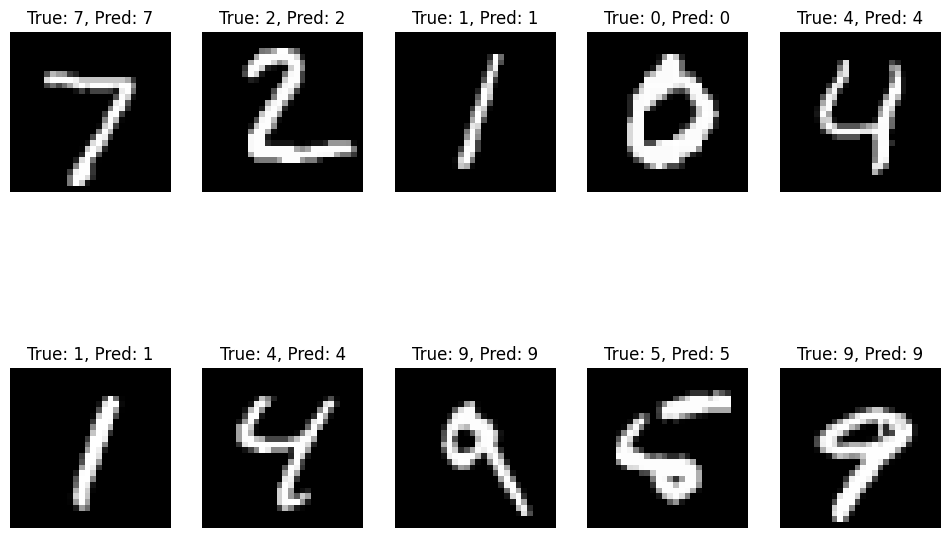

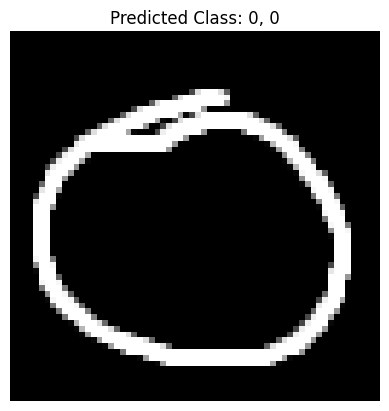

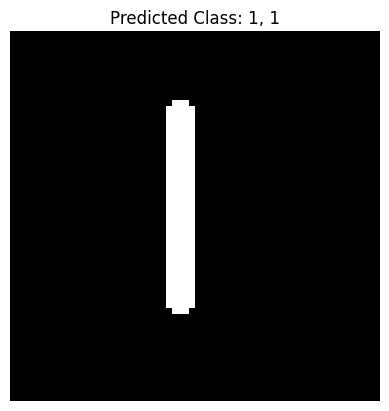

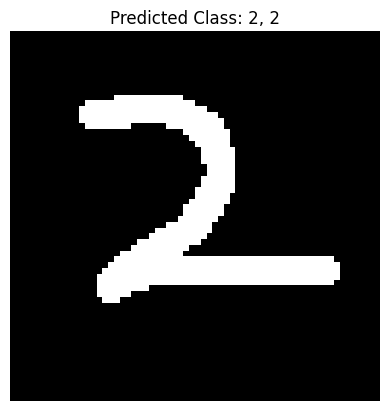

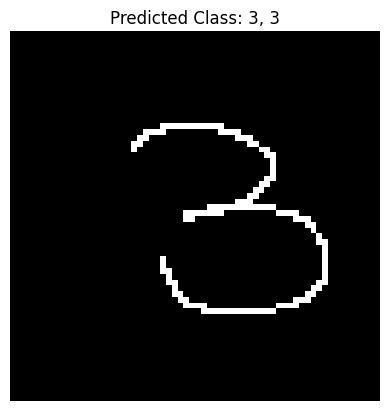

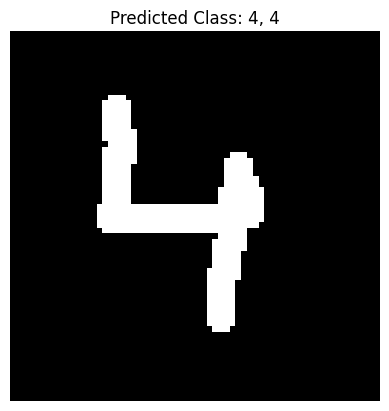

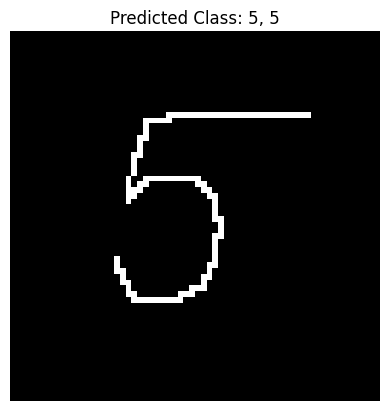

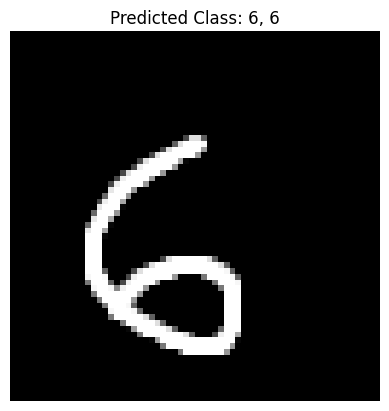

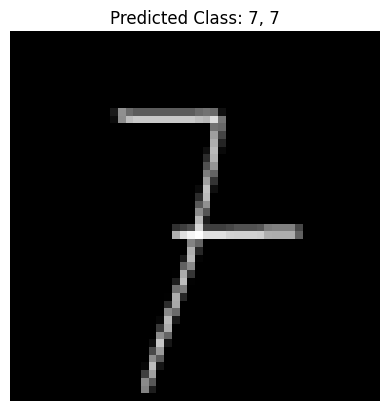

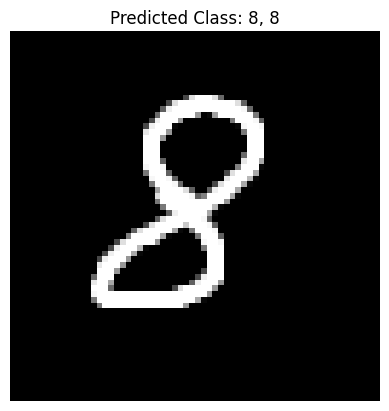

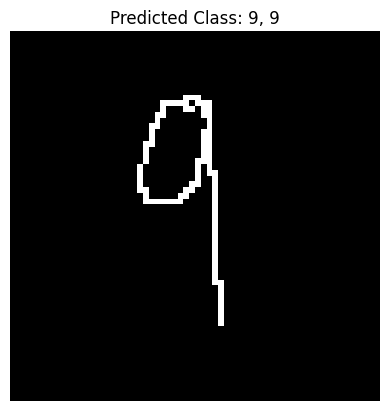

'\nTHIS IS FOR MAC/WINDOWS ONLY, THIS ALLOWS USER TO DRAW ON THE CANVAS AND SAVE THE IMAGE \nAND RUN PREDICTION MODEL ON IT TO GET PREDICTED TEXT.\n\n\n# Global variables for mouse position\nlast_x, last_y = None, None\n\ndef start_drawing(event):\n    # Start drawing when the left mouse button is pressed.\n    global last_x, last_y\n    last_x, last_y = event.x, event.y\n\ndef draw(event):\n    # Draw a line to the current mouse position\n    global last_x, last_y\n    # Draw on the canvas\n    canvas.create_line(last_x, last_y, event.x, event.y, smooth=True, capstyle="round", fill="black", width=12)\n    # Draw on the PIL Image\n    draw_image.line([last_x, last_y, event.x, event.y],fill="black", width=12)\n    last_x, last_y = event.x, event.y\n\ndef clear_canvas():\n    # Clear the entire canvas and reset the image.\n    canvas.delete("all")\n    draw_image.rectangle([0, 0, canvas_width, canvas_height], fill="white")\n\ndef save_and_predict_image():\n    # Predict the canvas drawin

In [ ]:
from tkinter import Tk, Canvas, Button
from PIL import Image, ImageDraw
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time
import torch.nn.functional as F
import cv2
from PIL import Image

class_labels = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}
model_path = './handwriting_classifier_default.pth'

# this is tracing the file print statements and sending to web page
model_initial = ""

# Transformer which converts the images, and normalizes it
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load EMNIST ByClass dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


train_data, val_data = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class HandwritingClassifier(nn.Module):
    def __init__(self, device=torch.device("cpu")):
        super(HandwritingClassifier, self).__init__()
        self.device = device

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # Output: 28x28x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 28x28x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 28x28x128

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout
        self.dropout = nn.Dropout(0.4)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)  # Adjust dimensions based on input size
        self.fc2 = nn.Linear(128, 10)  # 10 - MNSIT | 47 classes for EMNIST balanced

        self.to(device)

    def forward(self, x):
        x = x.to(self.device)

        # Convolutional layers with ReLU and Batch Normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: 14x14x32
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: 7x7x64
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Output: 3x3x128

        # Flatten the feature maps
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout to reduce overfitting
        x = self.fc2(x)  # Logits for 10 classes

        return x

if torch.cuda.is_available():
    model_initial += "CUDA is available!\n"
    model_initial += f"Number of GPUs: {torch.cuda.device_count()}\n"
    model_initial += f"Current GPU: {torch.cuda.current_device()}\n"
    model_initial += f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}\n"
else:
    model_initial += "CUDA is not available.\n"

print(model_initial, end="")




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HandwritingClassifier(device=device)

# compute loss for classification problems which results the value betweem 0 and 1
criterion = nn.CrossEntropyLoss()

# adam optimizer for gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.01,  momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# number of pass through dataset
epoches = 10

# Training function
def train_model(epochs):
    global model_initial;
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_labels).item()

        scheduler.step(val_loss / len(val_loader))
        print(f"Epoch {epoch + 1}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

    torch.save(model.state_dict(), "./handwriting_classifier_default.pth")
    model_initial += "Model Trained and Saved\n"
    print("Model Trained and Saved")



# Testing function
def test_model():
    global model_initial
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    model_initial += f"Accuracy: {accuracy:.2f}%\n"

start_time = time.time()

try:
    model_path = torch.load(model_path, weights_only=True)
    model.load_state_dict(model_path)
    # futher train the model
    print("Model Loaded, MNSIT [0-9]")
    model_initial += "Model Loaded\n"

except:
    model_path = None
    print("File not found, training a model!")
    print("Training...")
    model_initial += "File not found, training a model!\nTraining...\n"
    train_model(epoches)
    end_time = time.time()
    runtime = (end_time - start_time) / 60
    print("Model Trained. MNIST [0-9]")
    print(f'Time taken to train the model: {runtime} minutes')
    model_initial += "Model Trained.\n"
    model_initial += f'Time taken to train the model: {runtime} minutes'

model_initial += "Model Type: MNIST Digits [0-9]\n"
model_initial += "Testing a model\n"

"""UNCOMMENT these lines to test the model"""
# print("Testing a model")
test_model()


# Visualization
def visualize_predictions():
    model.eval()
    images, labels = next(iter(test_loader))
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {class_labels[labels[i].item()]}, Pred: {class_labels[predicted[i].item()]}")
        plt.axis('off')
    plt.show()


def visualize_user_defined_images():
    # these images are stored in folder ./images/[0-9].png
    for i in range(10):
        image = cv2.imread(f"./images/{i}.png")[:,:, 0]  # Read the image in grayscale
        image = np.invert(image)  # Invert the image (white becomes black and vice versa)
        image_pil = Image.fromarray(image)
        input_image = transform(image_pil).unsqueeze(0).to(device)
        # Optionally, visualize the image
        plt.imshow(image, cmap='gray')
        with torch.no_grad():  # Ensure no gradient calculation for inference
            output = model(input_image)
        predicted_class = output.argmax(dim=1).item()
        plt.title(f"Predicted Class: {predicted_class}, {class_labels[predicted_class]}")
        plt.axis("off")
        plt.show()


"""UNCOMMENT these lines to visualize the model"""

visualize_predictions()

"""UNCOMMENT these lines to test the USER DEFINED IMAGES"""
visualize_user_defined_images()



def predict_image(image_path):
    # Load the trained model
    model.eval()
    #  4 6 -:> Fine tune
    image = cv2.imread(image_path)[:,:, 0]  # Read the image in grayscale
    image = np.invert(image)  # Invert the image (white becomes black and vice versa)
    # make image more readable to model

    # Resize the image to 28x28
    # image_resized = cv2.resize(image, (28, 28))

    # Convert the image to PIL Image before passing to transform
    image_pil = Image.fromarray(image)

    # Transform the image to tensor and normalize it
    # Add a batch dimension and send the image to the correct device (CPU or GPU)
    input_image = transform(image_pil).unsqueeze(0).to(device)

    # Run the model and get the prediction
    with torch.no_grad():  # Ensure no gradient calculation for inference
        output = model(input_image)
    predicted_class = output.argmax(dim=1).item()
    # Print the predicted class
    # return f"Predicted Class: {predicted_class}, {class_labels[predicted_class]}"
    return class_labels[predicted_class]


def get_model_initial_prints():
    return model_initial



"""
THIS IS FOR MAC/WINDOWS ONLY, THIS ALLOWS USER TO DRAW ON THE CANVAS AND SAVE THE IMAGE
AND RUN PREDICTION MODEL ON IT TO GET PREDICTED TEXT.


# Global variables for mouse position
last_x, last_y = None, None

def start_drawing(event):
    # Start drawing when the left mouse button is pressed.
    global last_x, last_y
    last_x, last_y = event.x, event.y

def draw(event):
    # Draw a line to the current mouse position
    global last_x, last_y
    # Draw on the canvas
    canvas.create_line(last_x, last_y, event.x, event.y, smooth=True, capstyle="round", fill="black", width=12)
    # Draw on the PIL Image
    draw_image.line([last_x, last_y, event.x, event.y],fill="black", width=12)
    last_x, last_y = event.x, event.y

def clear_canvas():
    # Clear the entire canvas and reset the image.
    canvas.delete("all")
    draw_image.rectangle([0, 0, canvas_width, canvas_height], fill="white")

def save_and_predict_image():
    # Predict the canvas drawing to an image file.
    file_name = "./images/canvas_drawing.png"
    resized = image.resize((48,48))
    resized.save(file_name)
    predicted_output = f'Predicted Text: {predict_image(file_name)}'
    canvas.create_text(400, 50, text=predicted_output, font=("Arial", 24), fill="blue")

    print(f"Image saved as {file_name}")

# Initialize the main window
root = Tk()
root.title("Handwritten Digit Recoginition")

# Canvas dimensions
canvas_width, canvas_height = 1024, 1024

# Create a Canvas widget
canvas = Canvas(root, width=canvas_width, height=canvas_height, bg="white")
canvas.pack()

# Create a PIL Image to save the drawing
image = Image.new("RGB", (canvas_width, canvas_height), "white")
draw_image = ImageDraw.Draw(image)

# Bind mouse events to the canvas
canvas.bind("<Button-1>", start_drawing)  # Left mouse button pressed
canvas.bind("<B1-Motion>", draw)         # Mouse drag while left button pressed

# Add buttons
button_frame = Canvas(root, height=50)
button_frame.pack()

clear_button = Button(button_frame, text="Clear Canvas", command=clear_canvas)
clear_button.pack(side="left", padx=10, pady=5)

predict_btn = Button(button_frame, text="Predict", command=save_and_predict_image)
predict_btn.pack(side="right", padx=10, pady=5)


# Run the application
root.mainloop()


"""